# Yield Prediction using Molecular Descriptors_Prop Condensation_reactions

Found this dataset from a recent publication by a D.M. Makarov et al. (Journal of Computational Science 74 (2023) 102173)
(https://doi.org/10.1016/j.jocs.2023.102173)

"""We considered pyrrole or dipyrromethane condensation reactions 
with various aldehydes, resulting in the production of boron(III) 
dipyrromethene or BODIPY (681 records). These reactions were 
retrieved from articles (see “Dataset reactions” and Scheme S1). Addi
tionally, we used the reactions of the production of dipyrromethane 
(111 records) and porphyrins (457 records). All condensation reactions 
for dipyrromethanes and 213 reactions for porphyrins with various al
dehydes were obtained in our laboratory. The remaining 244 reactions 
for the porphyrins synthesis were obtained from articles (see “Dataset 
reactions”). Our experimental dataset is based on a study of pyrrole 
condensation processes with aldehydes, using catalytic amounts of 
organic acids to produce ms-aryl- and ß-alkyl-substituted dipyrro
methanes. """

The objective of this notebook is to introduce a method for predicting yield

As a beginner, there may be numerous opportunities for improvement in this notebook. I was largely inspired by the work of  D.M. Makarov et al and the STEPHEN LEE's notebook (BELKA: Molecule Representations for ML Tutorial) thanks to them.

# Data

In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from timeit import default_timer as timer

device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
pd.set_option('display.max_row',1245)
pd.set_option('display.max_columns',211)

In [3]:
# Téléchargement du Dataset contenant les descripteurs
DataFrame = r"C:\Users\loris\Condensation_reactions\descriptor_MolecularDescriptorCalculator.csv"

df = pd.read_csv(DataFrame)

df0= df.copy()

print(df0.shape)

(1245, 211)


In [5]:
# Téléchargement du Dataset original conteant la target 
DataFrame = r"C:\Users\loris\Condensation_reactions\y_yield_descriptor_MolecularDescriptorCalculator.csv"

df = pd.read_csv(DataFrame)

df1= df.copy()

print(df1.shape)

(1245, 7)


In [6]:
df = pd.concat([df0, df1], axis=1)
df.columns

Index(['Unnamed: 0', 'MaxAbsEStateIndex', 'MaxEStateIndex',
       'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt',
       'HeavyAtomMolWt', 'ExactMolWt',
       ...
       'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'Unnamed: 0', 'SMILES',
       'yield', 'Temperature', 'Ind', 'SMILES_2', 'mols'],
      dtype='object', length=218)

# Nettoyage du dataset 

In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,...,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SMILES,yield,Temperature,Ind,SMILES_2,mols
0,11.416308,11.416308,0.0,-0.833333,0.012051,12.781609,2358.078,2179.662,2356.321160,918,0,0.302558,-0.493270,0.493270,0.302558,0.333333,0.563218,0.781609,16.629148,9.825122,2.343436,-2.251196,2.508033,-2.148113,6.024309,-0.384444,1.593696,2.138103e-07,7677.093467,123.955082,106.071924,106.071924,81.641305,60.056261,60.056261,52.435446,52.435446,30.809508,30.809508,20.754451,20.754451,-17.300000,2.815209e+60,133.479956,58.352404,34.663585,1024.960610,88.964213,45.996095,12.572321,0.000000,11.656692,5.969305,29.292467,9.967957,0.000000,0.00000,251.956202,321.223733,150.741697,103.516794,83.161802,76.569201,0.000000,39.871828,0.0,292.960298,52.855056,395.935584,0.0,90.503707,37.894904,5.687386,45.996095,0.000000,143.326565,52.908998,10.114318,371.542290,273.508424,0.0,90.878495,0.0,409.24,16.861922,24.497930,0.00000,78.216327,75.480982,239.739347,45.513443,25.122838,61.185577,402.368656,62.870453,52.491755,0.000000,84.259068,25.145370,31.600497,4.681129,85.184436,25.095953,60.375125,0.000000,...,6,9,7,16,16,8,27,24,0,0,0,22,34.47070,704.2618,2,0,0,0,0,8,6,0,2,2,4,2,0,0,0,3,6,0,0,0,0,6,0,2,0,0,0,0,0,0,0,0,0,0,9,0,10,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,CC(C)(C)c1ccc(OCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C=...,0.05,20,78,CC(C)(C)c1ccc(OCCCCOc2ccc(C(C)(C)C)cc2C=O)c(C=...,<rdkit.Chem.rdchem.Mol object at 0x00000112152...
1,12.479397,12.479397,0.0,-4.819444,0.003717,12.276316,2176.610,2077.826,2172.512454,778,0,0.843138,-0.582447,0.843138,0.582447,0.401316,0.697368,1.006579,35.539267,9.926745,2.434

# Missing values

In [10]:
# Supprimes les valeurs manquantes
df.dropna(inplace=True)

In [11]:
df.shape

(1228, 216)

# Target 

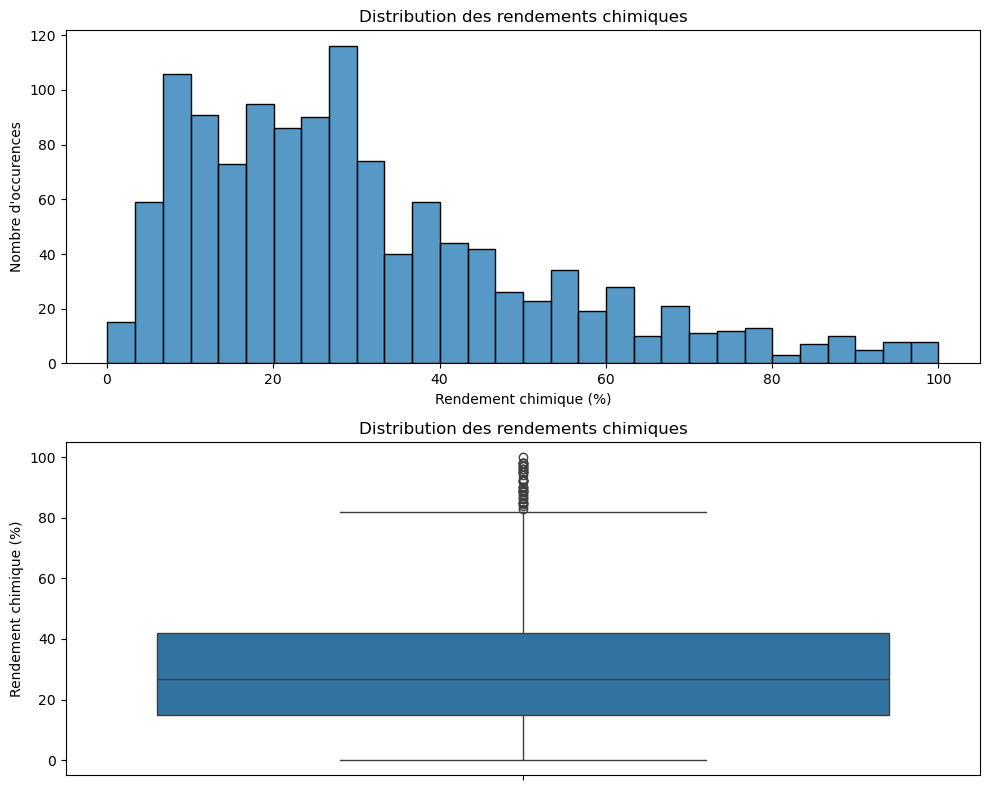

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Création de la figure et des axes pour les subplots
fig, axs = plt.subplots(2, 1, figsize=(10,8))

# Tracé de l'histogramme sur le premier subplot
sns.histplot(data=df, x='yield', bins=30, ax=axs[0])
axs[0].set_xlabel('Rendement chimique (%)')
axs[0].set_ylabel("Nombre d'occurences")
axs[0].set_title("Distribution des rendements chimiques")

# Tracé du boxplot sur le deuxième subplot
sns.boxplot(df["yield"], ax=axs[1])
axs[1].set_ylabel("Rendement chimique (%)")
axs[1].set_title("Distribution des rendements chimiques")

# Ajustement de l'espacement entre les subplots
plt.tight_layout()

# Affichage des graphiques 
plt.show()

# Filtrage des features

In [13]:
def filter_descriptors_low(data, threshold):
    # Drop colonne inutile
    data = data.drop(["SMILES", "Ind", "SMILES_2", "mols"], axis=1)
    # Copie des descripteurs
    descriptors = data.copy()
    
    # Calcul de la matrice de corrélation et mise à zéro de la diagonale
    corr = descriptors.corr()
    for index in corr.index:
        corr.loc[index, index] = 0
    
    # Préparation d'une liste pour collecter les noms des descripteurs non fortement corrélés
    descriptors_not_correlated = []
    
    # Vérifier chaque colonne individuellement
    for col in corr.columns:
        if all((corr[col][corr[col].notna()] <= threshold)):
            descriptors_not_correlated.append(col)
    
    print('Number of descriptors:', len(descriptors_not_correlated))
    
    # Retourner les données filtrées
    return data[descriptors_not_correlated]

In [14]:
df_desc = filter_descriptors_low(df, 0.9)
df_desc.shape

Number of descriptors: 129


(1228, 129)

# Préparation des données

In [15]:
# Séparation des features et de la target
X = df_desc.drop("yield", axis=1)
y = df_desc["yield"]

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion des données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Création des DataLoader PyTorch
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model 

In [16]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from timeit import default_timer as timer



In [17]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


In [20]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.cuda.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = RegressionModel().to(device)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.0612, -0.0285, -0.0653,  ...,  0.0224, -0.0257,  0.0057],
         [-0.0473, -0.0799,  0.0223,  ..., -0.0635, -0.0401,  0.0294],
         [ 0.0438, -0.0341, -0.0012,  ..., -0.0063,  0.0255, -0.0093],
         ...,
         [-0.0616, -0.0089,  0.0094,  ...,  0.0112, -0.0085,  0.0039],
         [-0.0241, -0.0388,  0.0817,  ...,  0.0147, -0.0020, -0.0872],
         [ 0.0483, -0.0621, -0.0417,  ..., -0.0344,  0.0333,  0.0181]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0461, -0.0834, -0.0837,  0.0758, -0.0369,  0.0054, -0.0519, -0.0474,
          0.0260, -0.0271, -0.0515, -0.0860, -0.0385, -0.0109,  0.0671, -0.0566,
          0.0080, -0.0277,  0.0527,  0.0299,  0.0707, -0.0720, -0.0161, -0.0498,
         -0.0876, -0.0438, -0.0256,  0.0098, -0.0758, -0.0180, -0.0093,  0.0112,
         -0.0862, -0.0005, -0.0280,  0.0849, -0.0030,  0.0562, -0.0071, -0.0241,
          0.0698, -0.0329, -0.0068,  0.0705, -0.0376, -0.0083,

In [21]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

In [22]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from timeit import default_timer as timer


torch.manual_seed(42)

# Paramètres d'entraînement
epochs = 125  # Nombre maximum d'époques
patience = 15  # Nombre d'époques à attendre pour l'amélioration du R²
best_r2 = -float('inf')
patience_counter = 0

# Initialiser le timer
train_time_start_on_cpu = timer()

# Loop through the data
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)
        
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y) # loss = compare model raw outputs to desired model outputs
        train_loss += loss

         # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 10 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)

      ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    model_0.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            test_y_pred = model_0(X)
            loss = loss_fn(test_y_pred, y)
            test_loss += loss.item()
            all_preds.extend(test_y_pred.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    test_loss /= len(test_loader)


    # Calcul des métriques
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    r2 = r2_score(all_targets, all_preds)

    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test MSE: {mse:.4f} | Test RMSE: {rmse:.4f} | Test R²: {r2:.4f}")

        # Early stopping
    if r2 > best_r2:
        best_r2 = r2
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
            
# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 0

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples


  2%|▏         | 3/125 [00:00<00:12,  9.69it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 1/125 | Train loss: 1382.1486 | Test loss: 1272.7100 | Test MSE: 1281.0116 | Test RMSE: 35.7912 | Test R²: -1.8836

Epoch: 1

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 2/125 | Train loss: 938.8113 | Test loss: 393.3581 | Test MSE: 398.6667 | Test RMSE: 19.9666 | Test R²: 0.1026

Epoch: 2

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 3/125 | Train loss: 441.1431 | Test loss: 316.7430 | Test MSE: 319.4982 | Test RMSE: 17.8745 | Test R²: 0.2808

Epoch: 3

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cib

  6%|▌         | 7/125 [00:00<00:08, 13.65it/s]

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 5/125 | Train loss: 371.9007 | Test loss: 248.4334 | Test MSE: 250.3696 | Test RMSE: 15.8231 | Test R²: 0.4364

Epoch: 5

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 6/125 | Train loss: 375.1692 | Test loss: 255.6295 | Test MSE: 257.3038 | Test RMSE: 16.0407 | Test R²: 0.4208

Patience counter: 1/15

Epoch: 6

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 7/125 | Train loss: 344.7166 | Test loss: 241.2196 | Test MSE: 242.5727 | Test RMSE: 15.5747 | Test R²: 0.4540

Epoch: 7

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 s

  9%|▉         | 11/125 [00:00<00:07, 15.22it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 8/125 | Train loss: 301.8029 | Test loss: 232.6107 | Test MSE: 234.3765 | Test RMSE: 15.3094 | Test R²: 0.4724

Epoch: 8

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 9/125 | Train loss: 324.0845 | Test loss: 226.7456 | Test MSE: 228.4042 | Test RMSE: 15.1130 | Test R²: 0.4858

Epoch: 9

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 10/125 | Train loss: 303.8268 | Test loss: 233.3097 | Test MSE: 235.0186 | Test RMSE: 15.3303 | Test R²: 0.4710

Patience counter: 1/15

Epoch: 10

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions conte

 10%|█         | 13/125 [00:00<00:07, 15.35it/s]

Epoch: 11

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 12/125 | Train loss: 322.0695 | Test loss: 227.5882 | Test MSE: 229.4606 | Test RMSE: 15.1480 | Test R²: 0.4835

Patience counter: 1/15

Epoch: 12

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 13/125 | Train loss: 298.5332 | Test loss: 224.5893 | Test MSE: 226.3850 | Test RMSE: 15.0461 | Test R²: 0.4904

Epoch: 13

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 14/125 | Train loss: 301.7605 | Test loss: 226.8425 | Test MSE: 228.7316 | Test RMSE: 15.1239 | Test R²: 0.4851

Patience counter: 1/15

Epoch: 14

-----

 14%|█▎        | 17/125 [00:01<00:07, 15.35it/s]

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 15/125 | Train loss: 303.2328 | Test loss: 216.6921 | Test MSE: 218.5580 | Test RMSE: 14.7837 | Test R²: 0.5080

Epoch: 15

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 16/125 | Train loss: 281.1929 | Test loss: 214.9354 | Test MSE: 216.9690 | Test RMSE: 14.7299 | Test R²: 0.5116

Epoch: 16

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 17/125 | Train loss: 296.7612 | Test loss: 215.4717 | Test MSE: 217.3146 | Test RMSE: 14.7416 | Test R²: 0.5108

Patience counter: 1/15

Epoch: 17

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples


 17%|█▋        | 21/125 [00:01<00:06, 15.74it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 18/125 | Train loss: 278.3816 | Test loss: 215.7497 | Test MSE: 217.4699 | Test RMSE: 14.7469 | Test R²: 0.5105

Patience counter: 2/15

Epoch: 18

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 19/125 | Train loss: 296.9995 | Test loss: 223.3920 | Test MSE: 224.8655 | Test RMSE: 14.9955 | Test R²: 0.4938

Patience counter: 3/15

Epoch: 19

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 20/125 | Train loss: 277.0518 | Test loss: 214.4253 | Test MSE: 216.2865 | Test RMSE: 14.7067 | Test R²: 0.5131

Epoch: 20

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/98

 18%|█▊        | 23/125 [00:01<00:06, 15.80it/s]

Epoch: 21

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 22/125 | Train loss: 280.6011 | Test loss: 221.4531 | Test MSE: 223.2161 | Test RMSE: 14.9404 | Test R²: 0.4975

Patience counter: 2/15

Epoch: 22

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 23/125 | Train loss: 285.3311 | Test loss: 219.8868 | Test MSE: 222.1208 | Test RMSE: 14.9037 | Test R²: 0.5000

Patience counter: 3/15

Epoch: 23

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 24/125 | Train loss: 272.1768 | Test loss: 217.3344 | Test MSE: 219.3968 | Test RMSE: 14.8120 | Test R²: 0.5061

Patience counter

 22%|██▏       | 27/125 [00:01<00:06, 16.20it/s]

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 25/125 | Train loss: 268.1831 | Test loss: 216.7864 | Test MSE: 218.3888 | Test RMSE: 14.7780 | Test R²: 0.5084

Patience counter: 5/15

Epoch: 25

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 26/125 | Train loss: 267.8168 | Test loss: 213.4103 | Test MSE: 215.2801 | Test RMSE: 14.6724 | Test R²: 0.5154

Epoch: 26

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 27/125 | Train loss: 297.1445 | Test loss: 217.0392 | Test MSE: 218.6419 | Test RMSE: 14.7865 | Test R²: 0.5078

Patience counter: 1/15

Epoch: 27

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/98

 25%|██▍       | 31/125 [00:02<00:05, 16.29it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 28/125 | Train loss: 278.1765 | Test loss: 217.6602 | Test MSE: 219.5602 | Test RMSE: 14.8176 | Test R²: 0.5058

Patience counter: 2/15

Epoch: 28

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 29/125 | Train loss: 279.3146 | Test loss: 213.0330 | Test MSE: 214.9805 | Test RMSE: 14.6622 | Test R²: 0.5161

Epoch: 29

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 30/125 | Train loss: 264.7405 | Test loss: 219.5996 | Test MSE: 221.6563 | Test RMSE: 14.8881 | Test R²: 0.5010

Patience counter: 1/15

Epoch: 30

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/98

 26%|██▋       | 33/125 [00:02<00:05, 15.93it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 32/125 | Train loss: 252.9942 | Test loss: 219.7947 | Test MSE: 221.6172 | Test RMSE: 14.8868 | Test R²: 0.5011

Patience counter: 3/15

Epoch: 32

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 33/125 | Train loss: 290.7301 | Test loss: 227.1021 | Test MSE: 229.3961 | Test RMSE: 15.1458 | Test R²: 0.4836

Patience counter: 4/15

Epoch: 33

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 34/125 | Train loss: 265.5923 | Test loss: 217.0550 | Test MSE: 219.1079 | Test RMSE: 14.8023 | Test R²: 0.5068

Patience counter: 5/15

Epoch: 34

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 s

 30%|██▉       | 37/125 [00:02<00:05, 15.98it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 35/125 | Train loss: 273.7481 | Test loss: 215.4440 | Test MSE: 217.7355 | Test RMSE: 14.7559 | Test R²: 0.5099

Patience counter: 6/15

Epoch: 35

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 36/125 | Train loss: 260.6161 | Test loss: 212.4747 | Test MSE: 214.6906 | Test RMSE: 14.6523 | Test R²: 0.5167

Epoch: 36

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 37/125 | Train loss: 253.8726 | Test loss: 208.2413 | Test MSE: 210.3716 | Test RMSE: 14.5042 | Test R²: 0.5264

Epoch: 37

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions c

 33%|███▎      | 41/125 [00:02<00:04, 16.92it/s]

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 39/125 | Train loss: 248.3149 | Test loss: 210.8133 | Test MSE: 212.6940 | Test RMSE: 14.5840 | Test R²: 0.5212

Patience counter: 1/15

Epoch: 39

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 40/125 | Train loss: 275.3869 | Test loss: 217.1166 | Test MSE: 219.2172 | Test RMSE: 14.8060 | Test R²: 0.5065

Patience counter: 2/15

Epoch: 40

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 41/125 | Train loss: 247.2413 | Test loss: 208.7093 | Test MSE: 210.7338 | Test RMSE: 14.5167 | Test R²: 0.5256

Patience counter: 3/15

Epoch: 41

-------

Looked at 0/982 samples

Looked at 320/982 s

 36%|███▌      | 45/125 [00:02<00:04, 17.55it/s]

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 43/125 | Train loss: 242.2269 | Test loss: 215.5436 | Test MSE: 217.5977 | Test RMSE: 14.7512 | Test R²: 0.5102

Patience counter: 5/15

Epoch: 43

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 44/125 | Train loss: 247.2642 | Test loss: 218.6224 | Test MSE: 221.0176 | Test RMSE: 14.8667 | Test R²: 0.5025

Patience counter: 6/15

Epoch: 44

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 45/125 | Train loss: 233.0576 | Test loss: 210.4541 | Test MSE: 212.3099 | Test RMSE: 14.5709 | Test R²: 0.5221

Patience counter: 7/15

Epoch: 45

-------

Looked at 0/982 s

 39%|███▉      | 49/125 [00:03<00:04, 17.08it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 46/125 | Train loss: 259.9062 | Test loss: 210.8502 | Test MSE: 213.1474 | Test RMSE: 14.5996 | Test R²: 0.5202

Patience counter: 8/15

Epoch: 46

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 47/125 | Train loss: 240.5008 | Test loss: 207.2768 | Test MSE: 209.5344 | Test RMSE: 14.4753 | Test R²: 0.5283

Epoch: 47

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 48/125 | Train loss: 243.0106 | Test loss: 210.3846 | Test MSE: 212.7496 | Test RMSE: 14.5859 | Test R²: 0.5211

Patience counter: 1/15

Epoch: 48

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/98

 41%|████      | 51/125 [00:03<00:04, 17.04it/s]

Epoch: 49

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 50/125 | Train loss: 244.4260 | Test loss: 217.0412 | Test MSE: 219.6289 | Test RMSE: 14.8199 | Test R²: 0.5056

Patience counter: 3/15

Epoch: 50

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 51/125 | Train loss: 259.3303 | Test loss: 211.5019 | Test MSE: 214.2865 | Test RMSE: 14.6385 | Test R²: 0.5176

Patience counter: 4/15

Epoch: 51

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 52/125 | Train loss: 240.5133 | Test loss: 205.9087 | Test MSE: 208.3457 | Test RMSE: 14.4342 | Test R²: 0.5310

Epoch: 52

-----

 44%|████▍     | 55/125 [00:03<00:04, 16.83it/s]

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 53/125 | Train loss: 252.0530 | Test loss: 208.4842 | Test MSE: 211.2350 | Test RMSE: 14.5339 | Test R²: 0.5245

Patience counter: 1/15

Epoch: 53

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 54/125 | Train loss: 247.5237 | Test loss: 215.7459 | Test MSE: 218.6991 | Test RMSE: 14.7885 | Test R²: 0.5077

Patience counter: 2/15

Epoch: 54

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 55/125 | Train loss: 249.9175 | Test loss: 206.3515 | Test MSE: 208.9824 | Test RMSE: 14.4562 | Test R²: 0.5296

Patience counter: 3/15

Epoch: 55

-------

Looked at 0/982 samples

Looked at 320/982 s

 47%|████▋     | 59/125 [00:03<00:03, 16.88it/s]

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 57/125 | Train loss: 254.5950 | Test loss: 214.6037 | Test MSE: 217.4043 | Test RMSE: 14.7446 | Test R²: 0.5106

Patience counter: 5/15

Epoch: 57

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 58/125 | Train loss: 255.1992 | Test loss: 206.1541 | Test MSE: 208.6944 | Test RMSE: 14.4463 | Test R²: 0.5302

Patience counter: 6/15

Epoch: 58

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 59/125 | Train loss: 257.4748 | Test loss: 215.6223 | Test MSE: 218.4499 | Test RMSE: 14.7800 | Test R²: 0.5083

Patience counter: 7/15

Epoch: 59

-------

Looked at 0/982 s

 50%|█████     | 63/125 [00:03<00:03, 17.38it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 60/125 | Train loss: 241.4003 | Test loss: 209.1995 | Test MSE: 211.4881 | Test RMSE: 14.5426 | Test R²: 0.5239

Patience counter: 8/15

Epoch: 60

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 61/125 | Train loss: 230.1516 | Test loss: 208.2085 | Test MSE: 210.4886 | Test RMSE: 14.5082 | Test R²: 0.5262

Patience counter: 9/15

Epoch: 61

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 62/125 | Train loss: 231.8731 | Test loss: 208.2181 | Test MSE: 210.4521 | Test RMSE: 14.5070 | Test R²: 0.5263

Patience counter: 10/15

Epoch: 62

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 

 54%|█████▎    | 67/125 [00:04<00:03, 17.16it/s]

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 64/125 | Train loss: 237.8517 | Test loss: 213.9324 | Test MSE: 216.2937 | Test RMSE: 14.7069 | Test R²: 0.5131

Patience counter: 12/15

Epoch: 64

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 65/125 | Train loss: 256.0384 | Test loss: 214.0536 | Test MSE: 216.5115 | Test RMSE: 14.7143 | Test R²: 0.5126

Patience counter: 13/15

Epoch: 65

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 66/125 | Train loss: 237.9184 | Test loss: 210.0420 | Test MSE: 212.2728 | Test RMSE: 14.5696 | Test R²: 0.5222

Patience counter: 14/15

Epoch: 66

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/98

 55%|█████▌    | 69/125 [00:04<00:03, 16.47it/s]

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 68/125 | Train loss: 231.5269 | Test loss: 207.2199 | Test MSE: 209.7254 | Test RMSE: 14.4819 | Test R²: 0.5279

Patience counter: 1/15

Epoch: 68

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 69/125 | Train loss: 229.4404 | Test loss: 204.6431 | Test MSE: 207.2093 | Test RMSE: 14.3948 | Test R²: 0.5336

Patience counter: 2/15

Epoch: 69

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 70/125 | Train loss: 228.8279 | Test loss: 205.2985 | Test MSE: 207.9101 | Test RMSE: 14.4191 | Test R²: 0.5320

Patience counter: 3/15

Epoch: 70

-

 58%|█████▊    | 73/125 [00:04<00:03, 16.77it/s]

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 71/125 | Train loss: 236.9474 | Test loss: 208.0641 | Test MSE: 211.0885 | Test RMSE: 14.5289 | Test R²: 0.5248

Patience counter: 4/15

Epoch: 71

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 72/125 | Train loss: 235.4691 | Test loss: 204.6686 | Test MSE: 207.6531 | Test RMSE: 14.4102 | Test R²: 0.5326

Patience counter: 5/15

Epoch: 72

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 73/125 | Train loss: 244.0824 | Test loss: 200.4312 | Test MSE: 203.1705 | Test RMSE: 14.2538 | Test R²: 0.5426

Epoch: 73

-------

Looked at 0/982 samples

Looked at 320/98

 62%|██████▏   | 77/125 [00:04<00:02, 17.28it/s]

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 74/125 | Train loss: 255.3573 | Test loss: 220.5491 | Test MSE: 223.8573 | Test RMSE: 14.9619 | Test R²: 0.4961

Patience counter: 1/15

Epoch: 74

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 75/125 | Train loss: 233.6776 | Test loss: 214.9521 | Test MSE: 218.1196 | Test RMSE: 14.7689 | Test R²: 0.5090

Patience counter: 2/15

Epoch: 75

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 76/125 | Train loss: 230.1740 | Test loss: 201.6267 | Test MSE: 204.5133 | Test RMSE: 14.3008 | Test R²: 0.5396

Patience counter: 3/15

Epoch: 76

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 s

 65%|██████▍   | 81/125 [00:05<00:02, 17.61it/s]

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 78/125 | Train loss: 250.1279 | Test loss: 200.6188 | Test MSE: 203.4985 | Test RMSE: 14.2653 | Test R²: 0.5419

Patience counter: 5/15

Epoch: 78

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 79/125 | Train loss: 232.3013 | Test loss: 201.8464 | Test MSE: 204.7097 | Test RMSE: 14.3077 | Test R²: 0.5392

Patience counter: 6/15

Epoch: 79

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 80/125 | Train loss: 243.3392 | Test loss: 212.4125 | Test MSE: 215.3193 | Test RMSE: 14.6738 | Test R²: 0.5153

Patience counter: 7/15

Epoch: 80

-------

Looked at 0/982 samples

Looked at 320/982 s

 66%|██████▋   | 83/125 [00:05<00:02, 17.77it/s]

Epoch: 81

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 82/125 | Train loss: 233.0366 | Test loss: 206.0145 | Test MSE: 209.4429 | Test RMSE: 14.4721 | Test R²: 0.5285

Patience counter: 9/15

Epoch: 82

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 83/125 | Train loss: 241.4082 | Test loss: 214.2040 | Test MSE: 217.5377 | Test RMSE: 14.7492 | Test R²: 0.5103

Patience counter: 10/15

Epoch: 83

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 84/125 | Train loss: 242.8861 | Test loss: 207.2723 | Test MSE: 210.6162 | Test RMSE: 14.5126 | Test R²: 0.5259

Patience counte

 70%|██████▉   | 87/125 [00:05<00:02, 15.98it/s]

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 85/125 | Train loss: 221.8504 | Test loss: 210.0636 | Test MSE: 213.0951 | Test RMSE: 14.5978 | Test R²: 0.5203

Patience counter: 12/15

Epoch: 85

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 86/125 | Train loss: 231.5720 | Test loss: 201.7851 | Test MSE: 204.6496 | Test RMSE: 14.3056 | Test R²: 0.5393

Patience counter: 13/15

Epoch: 86

-------

Looked at 0/982 samples

Looked at 320/982 samples

Looked at 640/982 samples

Looked at 660/982 samples

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 87/125 | Train loss: 230.5277 | Test loss: 203.9301 | Test MSE: 206.7811 | Test RMSE: 14.3799 | Test R²: 0.5345

Patience counter: 14/15

Epoch: 87

-------

Looked at 0/982 samples

Looked at 320/98

 70%|██████▉   | 87/125 [00:05<00:02, 15.93it/s]

Prédictions contenant des NaN :  0

Cibles contenant des NaN :  0

Epoch 88/125 | Train loss: 205.7603 | Test loss: 204.7238 | Test MSE: 207.5780 | Test RMSE: 14.4076 | Test R²: 0.5327

Patience counter: 15/15

Early stopping triggered!

Train time on cuda:0: 5.463 seconds


In [ ]:
#torch.save(model.state_dict(), "model.pth")
# print("Saved PyTorch Model State to model.pth")